# PESTPP-GLM

In this notebook, we will run PESTPP-GLM in standard parameter estimation mode and regularization mode.  In both cases, we will use the baked-in bayes-linear posterior monte carlo analysis to get posterior forecast PDFs.  We will use the prior monte carlo outputs as the prior forecast PDF.

In [1]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import flopy
import pyemu


flopy is installed in /Users/jeremyw/Dev/flopy/flopy


In [2]:
t_d = "template"
m_d = "master_glm"

In [3]:
pst = pyemu.Pst(os.path.join(t_d,"freyberg.pst"))
pst.write_par_summary_table(filename="none")

,type,transform,count,initial value,upper bound,lower bound,standard deviation
pp_vka2,pp_vka2,log,67,0,1,-1,0.5
grss3,grss3,log,705,0,1,-1,0.5
pp_hk1,pp_hk1,log,67,0,1,-1,0.5
welflux,welflux,log,2,0 to 0.176091,0.176091 to 0.30103,-0.30103 to 0,0.0752575 to 0.11928
rech4_cn,rech4_cn,log,1,0,0.0791812,-0.09691,0.0440228
grhk5,grhk5,log,705,0,1,-1,0.5
hk7_cn,hk7_cn,log,1,0,1,-1,0.5
pp_hk2,pp_hk2,log,67,0,1,-1,0.5
pp_strt0,pp_strt0,log,67,0,0.0211893,-0.0222764,0.0108664
vka6_cn,vka6_cn,log,1,0,1,-1,0.5


### reduce the number of adjustable parameters

This is the painful part: we cant use 10K pars because we cant wait around for that many runs and then the linear algebra of factoring a 10k by 10K matrix is also difficult.  So that means we need to fix a lot a parameters #frownyface

In [4]:
par = pst.parameter_data

In [5]:
# grid-scale pars
gr_pars = par.loc[par.pargp.apply(lambda x: "gr" in x),"parnme"]
par.loc[gr_pars,"partrans"] = "fixed"
pst.npar_adj

1215

In [27]:
# these are the sfr conductance parameters - Ive left all 40 adjustable
# but if you uncomment this, it will tie them into 1 parameter effectively
# strk_pars = par.loc[par.pargp=="strk","parnme"]
# p1 = strk_pars.iloc[0]
# par.loc[strk_pars.iloc[1:],"partrans"] = "tied"
# par.loc[strk_pars.iloc[1:],"partied"] = p1
# pst.npar_adj

In [7]:
par.loc[par.pargp.apply(lambda x: "pp" in x),"pargp"].unique()

array(['pp_hk0', 'pp_hk1', 'pp_hk2', 'pp_rech0', 'pp_rech1', 'pp_ss0',
       'pp_ss1', 'pp_ss2', 'pp_strt0', 'pp_strt1', 'pp_strt2', 'pp_sy0',
       'pp_sy1', 'pp_sy2', 'pp_vka0', 'pp_vka1', 'pp_vka2'], dtype=object)

Fix the storage pilot points - we still have layer-scale storage pars adjustable

In [8]:
s_pars = par.loc[par.pargp.apply(lambda x: "pp" in x and ("ss" in x or "sy" in x)),"parnme"]
par.loc[s_pars,"partrans"] = "fixed"
pst.npar_adj

813

In [9]:
adj_par = par.loc[par.partrans=="log",:]
adj_par.pargp.value_counts().sort_values()

ss7_cn          1
hk6_cn          1
ss8_cn          1
vka7_cn         1
flow            1
strt7_cn        1
sy6_cn          1
strt8_cn        1
vka8_cn         1
sy8_cn          1
hk7_cn          1
rech5_cn        1
rech4_cn        1
vka6_cn         1
hk8_cn          1
sy7_cn          1
strt6_cn        1
ss6_cn          1
welflux         2
welflux_k02     6
drncond_k00    10
strk           40
pp_vka1        67
pp_rech0       67
pp_vka0        67
pp_strt2       67
pp_rech1       67
pp_strt1       67
pp_strt0       67
pp_hk2         67
pp_hk1         67
pp_hk0         67
pp_vka2        67
Name: pargp, dtype: int64

fix the future recharge pilot points, vka in layers 1 and 3 and the initial condition pilot points (we still have layer-scale pars for each of these types)

In [28]:
fi_grps = ["pp_rech1","pp_vka0","pp_vka2","pp_strt0","pp_strt1","pp_strt2"]
par.loc[par.pargp.apply(lambda x: x in fi_grps),"partrans"] = "fixed"
pst.npar_adj

411

Ok, thats better...so lets run PESTPP-GLM.  We will use a single "base parameter" jacobian matrix as the basis for 6 super parameter iterations.  Then we will draw 100 realizations from the FOSM posterior parameter covariance matrix and run those 100 realizations to get the psoterior forecast PDFs

In [11]:
pst.control_data.noptmax = 6
pst.pestpp_options["n_iter_base"] = -1
pst.pestpp_options["n_iter_super"] = 6
pst.pestpp_options["num_reals"] = 100
pst.write(os.path.join(t_d,"freyberg_pp.pst"))

In [12]:
# pyemu.os_utils.start_slaves(t_d,"pestpp-glm","freyberg_pp.pst",num_slaves=20,slave_root=".",
#                            master_dir=m_d)

In [13]:
df = df=pd.read_csv(os.path.join(m_d,"freyberg_pp.post.obsen.csv"),index_col=0)
oe = pyemu.ObservationEnsemble.from_dataframe(pst=pst,df=df)

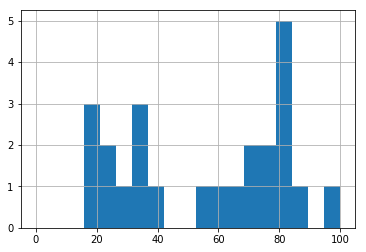

In [14]:
ax = oe.phi_vector.hist(bins=np.linspace(0,100,20))


Here we see the distribution of phi values across the 100 posterior realizations.  Should we accept all of these???  The theoretical phi we should accept is number of nonzero obs (14).

In [15]:
oe_pr = pd.read_csv(os.path.join("master_prior_sweep","sweep_out.csv"),index_col=0)

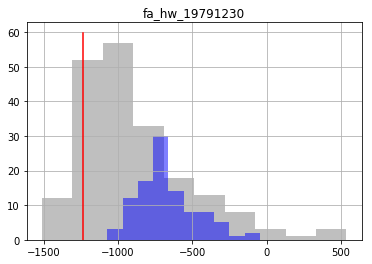

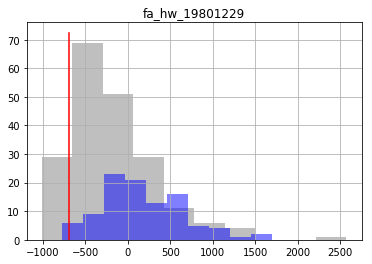

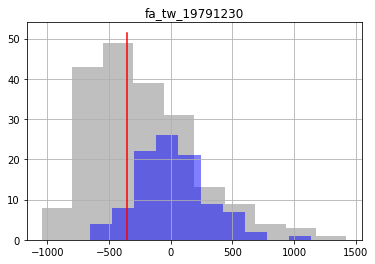

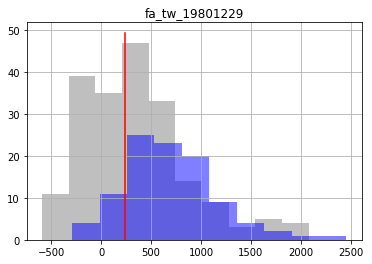

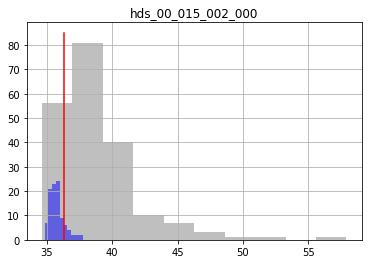

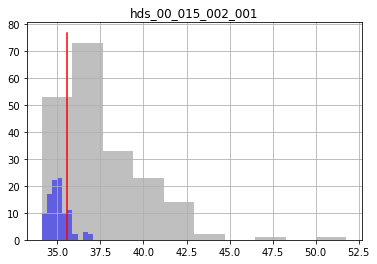

In [16]:
obs = pst.observation_data
fnames = pst.pestpp_options["forecasts"].split(",")
for forecast in fnames:
    ax = plt.subplot(111)
    oe_pr.loc[:,forecast].hist(ax=ax,color="0.5",alpha=0.5)
    oe.loc[:,forecast].hist(ax=ax,color="b",alpha=0.5)
    
    ax.plot([obs.loc[forecast,"obsval"],obs.loc[forecast,"obsval"]],ax.get_ylim(),"r")
    ax.set_title(forecast)
    plt.show()

All good...except sw-gw exchange in historic conditions.  That is not bracketed by the posterior. ruh roh!

### Setup of Tikhonov regularization

So lets setup and use some formal regularization to bring the final phi up to around 14.  We will use first-order regularization based on the covariance matrix we build earlier:

In [18]:
cov = pyemu.Cov.from_binary(os.path.join(t_d,"prior.jcb"))

In [19]:
pyemu.helpers.first_order_pearson_tikhonov(pst,cov)

getting CC matrix
processing


In [20]:
pst.prior_information.head()

,equation,obgnme,pilbl,weight
pilbl,,,,
pcc_1,1.0 * log(dc0000390005) - 1.0 * log(dc0000390006) = 0.0,regul_cc,pcc_1,0.904837
pcc_2,1.0 * log(dc0000390005) - 1.0 * log(dc0000390007) = 0.0,regul_cc,pcc_2,0.818731
pcc_3,1.0 * log(dc0000390005) - 1.0 * log(dc0000390008) = 0.0,regul_cc,pcc_3,0.740818
pcc_4,1.0 * log(dc0000390005) - 1.0 * log(dc0000390009) = 0.0,regul_cc,pcc_4,0.670320
pcc_5,1.0 * log(dc0000390005) - 1.0 * log(dc0000390010) = 0.0,regul_cc,pcc_5,0.606531


In [21]:
shutil.copy2(os.path.join(m_d,"freyberg_pp.jcb"),os.path.join(t_d,"restart_pp.jcb"))


'template/restart_pp.jcb'

In [22]:
pst.pestpp_options["base_jacobian"] = "restart_pp.jcb"
pst.reg_data.phimlim = pst.nnz_obs
pst.reg_data.phimaccept = pst.reg_data.phimlim * 1.1
pst.write(os.path.join(t_d,"freyberg_pp.pst"))

In [23]:
pyemu.os_utils.start_slaves(t_d,"pestpp-glm","freyberg_pp.pst",num_slaves=20,slave_root=".",
                           master_dir=m_d)

In [24]:
df = df=pd.read_csv(os.path.join(m_d,"freyberg_pp.post.obsen.csv"),index_col=0)
oe = pyemu.ObservationEnsemble.from_dataframe(pst=pst,df=df)

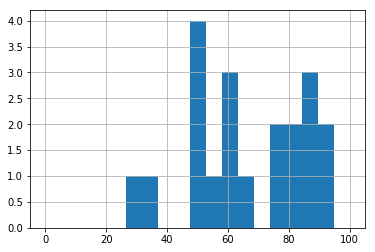

In [25]:
ax = oe.phi_vector.hist(bins=np.linspace(0,100,20))

An interesting point:  the use of Tikhonov seems to have pushed the phi values of the posterior realizations higher.

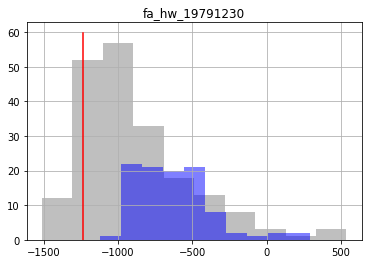

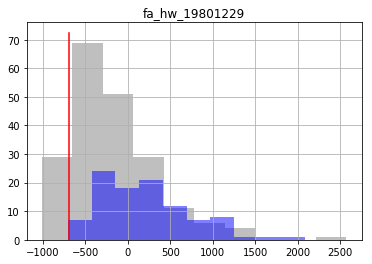

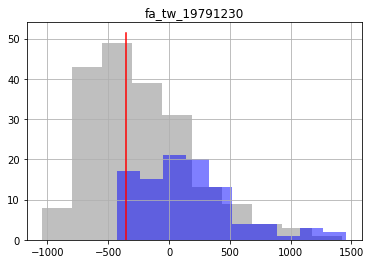

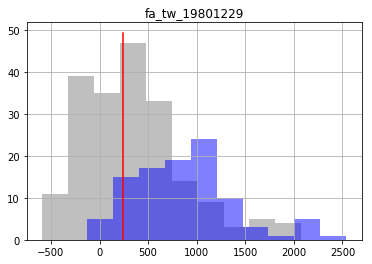

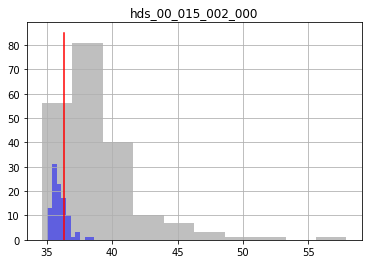

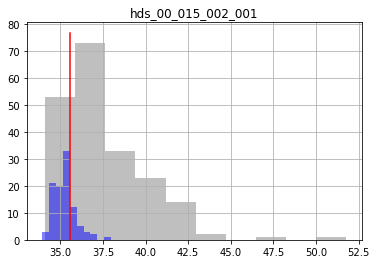

In [26]:
obs = pst.observation_data
fnames = pst.pestpp_options["forecasts"].split(",")
for forecast in fnames:
    ax = plt.subplot(111)
    oe_pr.loc[:,forecast].hist(ax=ax,color="0.5",alpha=0.5)
    oe.loc[:,forecast].hist(ax=ax,color="b",alpha=0.5)
    
    ax.plot([obs.loc[forecast,"obsval"],obs.loc[forecast,"obsval"]],ax.get_ylim(),"r")
    ax.set_title(forecast)
    plt.show()

Damn!